# Финальный проект: Прогнозирование оттока клиентов

## Неделя 5: Эксперименты с моделью прогнозирования оттока

** 2017/01/13**

*Юрий Исаков*

В рамках проекта мы будем решать задачу прогнозирования оттока пользователей, или churn prediction. Эта задача заключается в прогнозировании вероятности того, что клиент перестанет пользоваться сервисом в течение некоторого заданного заранее промежутка времени, например, решит перейти к конкуренту или откажется от использования услуги данного типа вообще.

Данные были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

---

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

In [1]:
# библиотеки
import pandas as pd
import numpy as np
import itertools
import xgboost as xgb

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# загрузка данных
train = pd.read_csv("data/orange_small_churn_train_data.csv")
train.loc[train['labels'] == -1, 'labels'] = 0
labels = train['labels'].copy()

# имена категориальных и числовых переменных
features_num = train.columns[1:191].tolist()
features_cat = train.columns[191:231].tolist()

# приводим типы
train[features_cat] = train[features_cat].astype(object)

# среднее по выборке
baseline = labels.mean()

## 1.  Как много объектов действительно нужно для построения качественной модели?

*Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`*

Здесь я буду работать только с числовыми признаками:

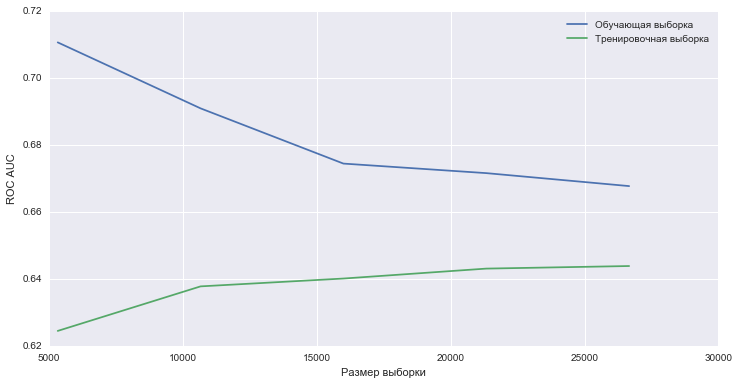

In [9]:
# заменяем пропущенные значения средними, выбросим пустые колонки и нормализуем
X1 = train[features_num].copy()
X1 = X1.fillna(X1.mean())
X1 = X1.dropna(axis=1,how='all')
X1 = pd.DataFrame(StandardScaler().fit_transform(X1))

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), X1, labels, cv=3, scoring='roc_auc',
                                                       train_sizes=[0.2, 0.4, 0.6, 0.8, 1])
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u"Обучающая выборка")
plt.plot(train_sizes, test_scores.mean(axis=1), label=u"Тренировочная выборка")
plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.legend(loc="best")
plt.show()

del train_sizes, train_scores, test_scores

Как видно из графика, метрика на тестовой выборке продолжает расти с увеличением обучающей выборки. Поэтому на этом объеме чем больше, тем лучше.

## 2. Баланс классов 
*Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.*

### 2.1 Задайте веса объектам

*Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?*

В исходной выборке положительный класс составляет ~7.4%, т.е. соотношение отрицательного и положительного классов составляет 13:1. Воспользуемся параметром class_weight в логистической регрессии и посмотрим на что он влияет:

In [3]:
# печатаем метрики по кросс-валидации
def get_cv_roc_pr_rc(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        y_pred = clf.predict(X.iloc[test,:])
        y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(metrics.roc_auc_score(y.iloc[test], y_pred_prob))
        pr_auc.append(metrics.average_precision_score(y.iloc[test], y_pred_prob))
        precision.append(metrics.precision_score(y.iloc[test], y_pred))
        recall.append(metrics.recall_score(y.iloc[test], y_pred))

    print 'ROC-AUC:', np.mean(roc_auc)
    print 'PR-AUC:', np.mean(pr_auc)
    print 'Precission:', np.mean(precision)
    print 'Recall:', np.mean(recall)
    
    return roc_auc, pr_auc, precision, recall, models

In [10]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, labels)

ROC-AUC: 0.643830517676
PR-AUC: 0.120057132869
Precission: 0.1
Recall: 0.00201612903226


In [11]:
w = {0: 3, 1: 1}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, labels)

ROC-AUC: 0.643362278366
PR-AUC: 0.11997157512
Precission: 0.0277777777778
Recall: 0.000336021505376


In [12]:
w = {0: 1, 1: 3}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, labels)

ROC-AUC: 0.643523063845
PR-AUC: 0.119239923398
Precission: 0.166644461401
Recall: 0.0127688172043


In [13]:
w = {0: 1, 1: 13}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, labels)

ROC-AUC: 0.640701126383
PR-AUC: 0.116379254852
Precission: 0.105783982902
Recall: 0.668010752688


Изменяя веса каждого класса, мы в большей степени влияем на точность и полноту, чем на остальные метрики.

### 2.2 Примените к выборке технологию undersampling
*Для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?*

In [14]:
# найдем индексы обоих классов
idx_0 = X1[labels == 0].index.tolist()
idx_1 = X1[labels == 1].index.tolist()

# наблюдения, которые оставим в трех случаях
undersample_1 = list(np.random.choice(idx_0, 3*len(idx_1)))
undersample_2 = list(np.random.choice(idx_0, 1*len(idx_1)))
undersample_3 = list(np.random.choice(idx_0, len(idx_1)/3))

# посчитаем соотношение классов
print np.mean(labels[undersample_1 + idx_1]), np.mean(labels[undersample_2 + idx_1]),\
    np.mean(labels[undersample_3 + idx_1])

0.25 0.5 0.75


In [15]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf,\
        X1.ix[undersample_1 + idx_1], labels[undersample_1 + idx_1])

ROC-AUC: 0.6450432989
PR-AUC: 0.355954534678
Precission: 0.441338067981
Recall: 0.0460349462366


In [16]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf,\
        X1.ix[undersample_2 + idx_1], labels[undersample_2 + idx_1])

ROC-AUC: 0.635229178861
PR-AUC: 0.594643399951
Precission: 0.592382313411
Recall: 0.665994623656


In [17]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf,\
        X1.ix[undersample_3 + idx_1], labels[undersample_3 + idx_1])

ROC-AUC: 0.598890055412
PR-AUC: 0.782977354417
Precission: 0.763204771539
Recall: 0.956317204301


Основная метрика (ROC AUC) несколько падает, если выбрасывать объекты доминирующего класса, зато сильно растут точность и полнота. В этом нет ничего удивительного, в выборке теперь значительно меньше объектов отрицательного класса. В целом, изменение весов и андерсэмплинг ничего не дал.

## 3. Обработкa пропущенных значений
*Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?*

In [4]:
# звыбросим пустые колонки из исходного датасета
X2 = train[features_num].copy()
X2 = X2.dropna(axis=1,how='all')

In [25]:
# замена пропущенных значений на средние
X2_mean = X2.fillna(X2.mean())
X2_mean = pd.DataFrame(StandardScaler().fit_transform(X2_mean))

skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X2_mean, labels)

ROC-AUC: 0.645532356697
PR-AUC: 0.122301977977
Precission: 0.159047619048
Recall: 0.0023518132085


In [5]:
# замена пропущенных значений на медианы
X2_median = X2.fillna(X2.median())
X2_median = pd.DataFrame(StandardScaler().fit_transform(X2_median))

skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X2_median, labels)

ROC-AUC: 0.651953157307
PR-AUC: 0.125152173991
Precission: 0.110793650794
Recall: 0.00134397383114


Медианы работают немного лучше. Добавим дополнительный признак -- пропущено ли значение в исходной таблице и опять посчитаем метрики для средних и медиан:

In [6]:
# создадим признак: пропущенно ли значение в колонке
X2_nan = X2.isnull()
X2_nan.columns = ['nan_'] + X2_nan.columns

In [37]:
# замена пропущенных значений на средние и использование дамми
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, pd.concat([X2_mean, X2_nan], axis=1), labels)

ROC-AUC: 0.689529643641
PR-AUC: 0.148929995926
Precission: 0.02
Recall: 0.000336134453782


In [36]:
# замена пропущенных значений на медианы и использование дамми
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, pd.concat([X2_median, X2_nan], axis=1), labels)

ROC-AUC: 0.689541685369
PR-AUC: 0.148962758049
Precission: 0.02
Recall: 0.000336134453782


Использование бинарного признака о пропущенном значении может заметно улучшить метрику.

## 4. Обработка категориальных признаков
*Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?*

Как правило, в этом случае применяют два основных метода, дамми кодирование признака или замена на среднее (частоте) по целевой переменной. 

Второй метод несколько сложнее и его нельзя реализовывать напрямую через методы sklearn (хотя эти реализации часто встречаются в работах). И вот почему: для того, чтобы проводить кросс-валидацию нужен готовый датасет со всеми рассчитанными признаками. Предположим мы берем первый фолд и у нас есть обучающая и тестовая выборки, здесь правильно рассчитать средние по обучающей и применить на тестовой. И точно так же поступить для остальных разбиений. Но простой реалзиации здесь нет, поэтому часто рассчитывают средние по всей выборке сразу, а проводят кросс-валидацию потом. Очевидно, что такой способ ведет к утечке (подробнее можно посмотреть, например, на докладе Станислава Семенова о соревновании на Kaggle BNP Paribas). По этой причине я не буду приводить здесь код для этого метода, а рассмотрю только дамми-кодирование.

Возможен и третий подход, можно отсортировать уникальные значения признака в порядке в зависимости от того, как часто при них встречается положительный класс. Тогда мы получим порядковый признак. Для него необходимо проводить кросс-валидацию указанным выше, осторожным методом.

In [7]:
# обработаем категории
X3 = train[features_cat].dropna(axis=1,how='all').copy()
# заменим наны
X3 = X3.fillna('fakenan')
# посчитаем количество уникальных значений и отберем те, где меньше 250 уникальных
counts = pd.Series([len(X3[X3.columns[i]].value_counts()) for i in range(len(X3.columns))], index = X3.columns)
vars_2dummy = counts[counts <250].index
# составим дамми переменные
X3_dummy = pd.get_dummies(X3[vars_2dummy])
# уберем дубликаты
X3_dummy = X3_dummy.T.drop_duplicates().T

In [82]:
# проверим на кросс-валидации
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models =\
    get_cv_roc_pr_rc(clf, skf, pd.concat([X2_median, X2_nan, X3_dummy], axis=1), labels)

ROC-AUC: 0.702141573587
PR-AUC: 0.171620565444
Precission: 0.336075861591
Recall: 0.017136653319


Качество повысилось от добавления дамми-переменных. 

## 5. Отбор признаков 
*Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.*

In [8]:
X4 = pd.concat([X2_median, X2_nan, X3_dummy], axis=1)
clf = LogisticRegression()

In [129]:
# попробуем 200 лучших переменных
kb100 = SelectKBest(k=100).fit(X4, labels)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X4.ix[:, kb100.get_support()], labels)

ROC-AUC: 0.720511326158
PR-AUC: 0.186360803707
Precission: 0.355062845651
Recall: 0.00840054142462


In [9]:
# попробуем 300 лучших переменных
kb300 = SelectKBest(k=300).fit(X4, labels)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X4.ix[:, kb300.get_support()], labels)

/Users/yuri/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [106 220 236 275] are constant.
  UserWarning)
/Users/yuri/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


ROC-AUC: 0.723131504467
PR-AUC: 0.192205919983
Precission: 0.403174603175
Recall: 0.0120952004963


In [131]:
# попробуем 400 лучших переменных
kb400 = SelectKBest(k=400).fit(X4, labels)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X4.ix[:, kb400.get_support()], labels)

ROC-AUC: 0.721899869788
PR-AUC: 0.189786473114
Precission: 0.381729323308
Recall: 0.0120957644803


Обучим классикатор с L1 регуляризатором у которого подберем коэффициент регуляризации по кросс-валидации. Используя науилучший классификатор отберем признаки. Обучим классификатор с отобранными признаками и проверим метрики:

In [181]:
# подбираем оптимальное значение коэффициента регуляризации
lr_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=3, scoring='roc_auc').fit(X4, labels)
X_lr = SelectFromModel(lr_l1, prefit=True).transform(X4)
# осталось признаков
X_lr.shape[1]

119

In [182]:
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, pd.DataFrame(X_lr), labels)

ROC-AUC: 0.721436213958
PR-AUC: 0.18590226433
Precission: 0.339760348584
Recall: 0.009407816818


Оба метода имеют право на жизнь. Первый оставил 300 переменных, второй 119. Качество примерно одинаковое.

## 6. Настройка гиперпараметров
*Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`). Как подбор параметров повлиял на качество модели?*

У логистической регресси, которая была использована выше только один гиперпараметр. Подберем гиперпараметры для xgboost классификатора обучая его по сетке возможных значений:

In [ ]:
# оставляем эти признаки
X5 = X4.ix[:, kb300.get_support()]

In [10]:
# попробуем xgboost
bst = xgb.XGBClassifier(n_estimators=100)
params = {'max_depth': [2, 3, 4],
          'learning_rate': [0.05, 0.1],
          'subsample': [0.8, 1.0]}

xgb_grid = GridSearchCV(bst, params, scoring = 'roc_auc', cv=3, n_jobs=-1, verbose=1)

xgb_grid.fit(X5, labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.8, 1.0], 'learning_rate': [0.05, 0.1], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [14]:
pd.DataFrame(xgb_grid.cv_results_).ix[:, 2:7]

,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_subsample
0,0.731584,0.744176,0.05,2,0.8
1,0.730872,0.743953,0.05,2,1
2,0.738310,0.763459,0.05,3,0.8
3,0.738392,0.762963,0.05,3,1
4,0.739874,0.786612,0.05,4,0.8
5,0.739521,0.785658,0.05,4,1
6,0.739928,0.760543,0.1,2,0.8
7,0.738877,0.759919,0.1,2,1
8,0.742242,0.789400,0.1,3,0.8
9,0.740924,0.787722,0.1,3,1


In [12]:
# оптимальные параметры
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

Таким образом, мы обучили классификатор с оптимальными параметрами. На данный момент она показала максимальное качество.

## 7. Влияние признаков на модель
*Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?*

Воспользуемся оценкой важности признаков классификатора xgboost:

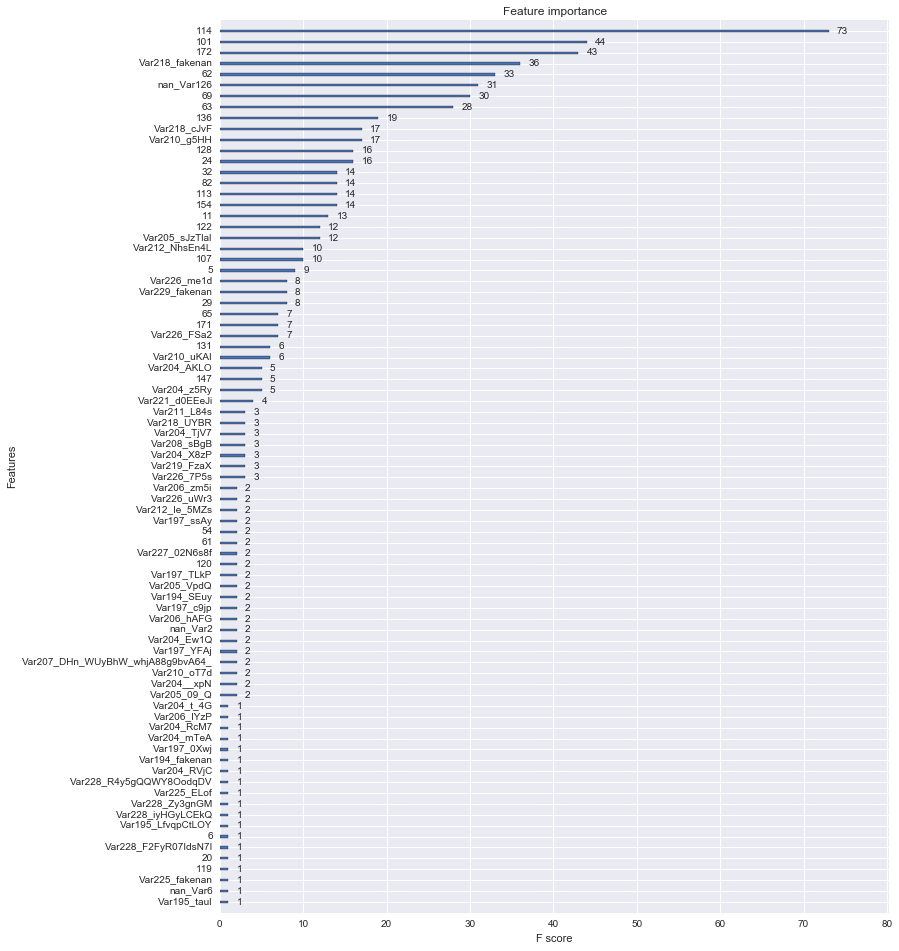

In [28]:
fig, ax = plt.subplots(figsize=(12, 16))
plot_importance(xgb_grid.best_estimator_, ax=ax)
pyplot.show()

По оценке xgboost из 10 наиболее важных признаков, 8 являются числовыми.

## 8. Анализ ошибок классификации
*Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).*

Посмотрим на распределения по вероятностям:

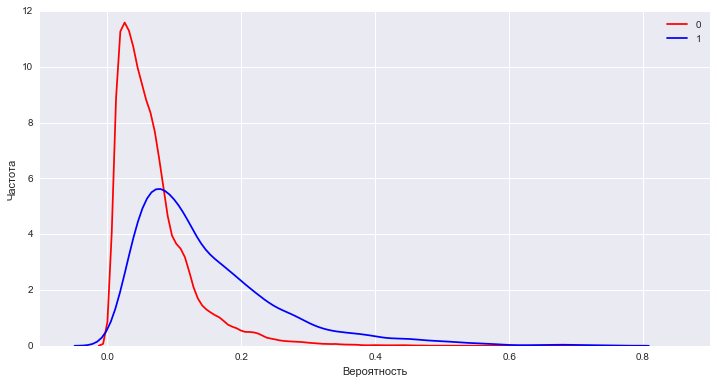

In [127]:
fig, ax = plt.subplots(figsize=(12, 6))

pred = pd.Series(xgb_grid.best_estimator_.predict_proba(X5)[:,1])
# гистограмма отклонений от истинных значений
sns.kdeplot(pred[labels == 0], color = 'r', ax=ax, label=0)
sns.kdeplot(pred[labels == 1], color = 'b', ax=ax, label=1)
plt.ylabel(u'Частота')
plt.xlabel(u'Вероятность')
plt.show()

Большинству объектов положительного класса предсказываются маленькие вероятности (до 0.2). Сравим средние значения по важным (по мнению xgboost) признакам для явно ошибочных предсказаний и для более-менее правдоподобных. Сравним разницу:

In [182]:
idx_low = pred[(pred < 0.05) & (labels == 1)].index
idx_high = pred[(pred > 0.3) & (labels == 1)].index

means_low = X5.ix[idx_low, (xgb_grid.best_estimator_.feature_importances_ != 0).tolist()].mean()
means_high = X5.ix[idx_high, (xgb_grid.best_estimator_.feature_importances_ != 0).tolist()].mean()

diff = pd.DataFrame(dict(means_low = means_low, means_high = means_high))
diff['abs_diff'] = abs(diff['means_high'] - diff['means_low'])
diff.sort_values('abs_diff', ascending=False)[:15]

,means_high,means_low,abs_diff
172,-0.849364,0.096011,0.945375
62,-0.623568,0.253188,0.876756
6,-0.622790,0.224740,0.847531
101,0.610615,-0.152397,0.763011
131,-0.419862,0.318993,0.738856
69,0.555431,-0.070366,0.625796
11,-0.364357,0.142655,0.507013
54,-0.279029,0.174376,0.453405
Var218_cJvF,0.123077,0.549180,0.426103
Var212_NhsEn4L,0.869231,0.453552,0.415679


Как видно из таблицы, наши признаки недостаточно хороши, чтобы отделять один хвостик распределения от другуго. Возможно, придумывание новых признаков могло бы помочь.

## 9. Финальная модель
*По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.*

Для финального решения я бы оставил классификатор xgboost. Пропуски в числовых переменных заменил бы медианой и составил дамми-признаки пропусков. Категориальные переменные можно тоже перевести в дамми или (аккуратно) перевести в средние по целевой переменной. Отбор признаков провести с помощью оценки важности признаков xgboost или SelectKBest.

## 10. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Модели может помочь создание новых признаков (например, взаимодействие категорий). Так же можно объединить разные модели в ансамбль.